inspired by https://github.com/Data-Monkey/GTFS-NetworkX/blob/master/GTFStoGraph.py

GTFS API: https://developers.google.com/transit/gtfs/reference#agencytxt

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

### Import the GTFS Files

In [2]:
ROUTES = pd.read_csv('cta_data/routes.txt')
STOPS = pd.read_csv('cta_data/stops.txt')
TRIPS = pd.read_csv('cta_data/trips.txt')
STOP_TIMES = pd.read_csv('cta_data/stop_times.txt')

### Clean the Data for "L" Train info only

We (for now) only want to model subways/metros, which use `route_type=1`, so we get a list of the `route_id`s that correspond ot the subway ("L") lines

In [3]:
ROUTES_subway = ROUTES[ROUTES['route_type']==1]
# record subway route_ids
route_ids_subway = ROUTES_subway['route_id'].values.tolist()
ROUTES_subway

,route_id,route_short_name,route_long_name,route_type,route_url,route_color,route_text_color
126,Red,NaN,Red Line,1,http://www.transitchicago.com/redline/,C60C30,FFFFFF
127,P,NaN,Purple Line,1,http://www.transitchicago.com/purpleline/,522398,FFFFFF
128,Y,NaN,Yellow Line,1,http://www.transitchicago.com/yellowline/,F9E300,000000
129,Blue,NaN,Blue Line,1,http://www.transitchicago.com/blueline/,00A1DE,FFFFFF
130,Pink,NaN,Pink Line,1,http://www.transitchicago.com/pinkline/,E27EA6,FFFFFF
131,G,NaN,Green Line,1,http://www.transitchicago.com/greenline/,009B3A,FFFFFF
132,Org,NaN,Orange Line,1,http://www.transitchicago.com/orangeline/,F9461C,FFFFFF
133,Brn,NaN,Brown Line,1,http://www.transitchicago.com/brownline/,62361B,FFFFFF


Likewise, we will filter the `TRIPS` data so that it only includes trips for subway routes:

In [4]:
# filter to only include trips with subway route_ids
TRIPS_subway = TRIPS[TRIPS['route_id'].isin(route_ids_subway)]

# only include one direction to avoid redundancies
# TRIPS_subway = TRIPS_subway[TRIPS_subway['direction_id']==1]
trip_ids_subway = list(TRIPS_subway['trip_id'].values)
TRIPS_subway

,route_id,service_id,trip_id,direction_id,block_id,shape_id,direction,wheelchair_accessible,schd_trip_id
41967,Blue,106001,60166141078,1,60015964004,306000124,North,1,R129
41968,Blue,106001,60166141079,0,60015964047,306000002,South,1,R133
41969,Blue,106001,60166141080,0,60015964047,306000002,South,1,R219
41970,Blue,106001,60166141081,1,60015964047,306000001,North,1,R219
41971,Blue,106001,60166141085,0,60015963974,306000002,South,1,R146
...,...,...,...,...,...,...,...,...,...
47041,Y,106009,60161865594,0,60015582422,306000033,0,1,R593
47042,Y,106009,60161865595,0,60015582423,306000033,0,1,R594
47043,Y,106009,60161865597,0,60015582422,306000033,0,1,R591
47044,Y,106009,60161865598,0,60015582423,306000033,0,1,R592


In [5]:
STOP_TIMES_subway = STOP_TIMES[STOP_TIMES['trip_id'].isin(trip_ids_subway)].reset_index()
STOP_TIMES_subway[STOP_TIMES_subway['pickup_type'] == 0]


,index,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,shape_dist_traveled
0,0,60161865358,06:31:00,06:31:00,30175,1,Skokie,0,0
1,1,60161865358,06:37:30,06:37:30,30297,2,Skokie,0,21220
2,2,60161865358,06:39:00,06:39:00,30026,3,Skokie,0,26031
3,3,60161865358,06:45:00,06:45:00,30027,4,Howard,0,26031
4,4,60161865358,06:47:00,06:47:00,30298,5,Howard,0,30842
...,...,...,...,...,...,...,...,...,...
132815,144431,60166205030,18:42:30,18:42:30,30216,18,Midway,0,79784
132816,144432,60166205030,18:44:30,18:44:30,30206,19,Midway,0,85228
132817,144433,60166205030,18:46:30,18:46:30,30023,20,Midway,0,90716
132818,144434,60166205030,18:50:30,18:50:30,30061,21,Midway,0,101776


We only want to track `stations` (`location_type=1`), but `STOP_TIMES` gives information for `platforms`(`location_type=0`). So first we need to assign the parent for each of the stops in `STOP_TIMES`

In [6]:
STOPS_stations = STOPS[STOPS['location_type']==1]
# stop_ids_stations = list(STOPS_stations['stop_id'].unique())

In [7]:
def get_parent(stop_id):
    parent = STOPS[STOPS['stop_id']==stop_id]['parent_station'].values
    if len(parent) == 0:
        return stop_id
    else:
        return parent[0]

STOP_TIMES_subway['station_id'] = STOP_TIMES_subway['stop_id'].apply(get_parent)

### use trip information to determine graph edges

In [8]:
origin_stops = []
dest_stops = []
trip_ids = []

edges_list = []
for trip_id, group in STOP_TIMES_subway.groupby('trip_id'):
    for i in group.index[:-1]:
        origin_stop = STOP_TIMES_subway['station_id'][i]
#         print(i)
        dest_stop = STOP_TIMES_subway['station_id'][i+1]
        if STOP_TIMES_subway['stop_sequence'][i+1] - STOP_TIMES_subway['stop_sequence'][i] == 1:
            origin_stops.append(origin_stop)
            dest_stops.append(dest_stop)
            trip_ids.append(trip_id)
            edges_list.append((origin_stop, dest_stop))

In [9]:
len(STOP_TIMES_subway['trip_id'].unique())

4420

In [10]:
edges = pd.DataFrame({'origin_stop':origin_stops, 'dest_stop':dest_stops, 'trip_id':trip_ids})
edges

,origin_stop,dest_stop,trip_id
0,40900.0,41680.0,60161865358
1,41680.0,40140.0,60161865358
2,40140.0,40140.0,60161865358
3,40140.0,41680.0,60161865358
4,41680.0,40900.0,60161865358
...,...,...,...
127618,41060.0,40120.0,60166205118
127619,40120.0,40310.0,60166205118
127620,40310.0,41150.0,60166205118
127621,41150.0,40960.0,60166205118


### Let's play around with just stops data:

In [11]:
l_stops_raw = pd.read_csv("cta_data/CTA_-_System_Information_-_List_of__L__Stops_-_Map.csv")
# convert coords to a readable dict
locations = l_stops_raw.Location.apply(lambda x: x[1:-1].split(","))
coords = pd.DataFrame(locations.tolist(), columns=['lat', 'long']).astype('float')

l_stops = l_stops_raw.drop(['Location'], axis=1)
l_stops = l_stops.join(coords)

In [12]:
l_stops['STATION_ID'] = l_stops['STOP_ID'].apply(get_parent)

In [13]:
# read in stop colors
stop_colors = l_stops[['STATION_ID', 'RED', 'BLUE', 'G', 'BRN', 'P', 'Pexp', 'Y','Pnk', 'O']]

color_conversion = {'RED':'red', 'BLUE':'blue', 'G':'green', 'BRN':'brown', 'P':'purple', 'Pexp':'purple', 'Y':'yellow','Pnk':'pink', 'O':'orange'}

colors_dict = {}
for i in stop_colors.index:
    colors_list = []
    for c in stop_colors.columns.astype('str'):
        if stop_colors[c][i] == True:
            colors_list.append(color_conversion[c])
    if len(colors_list) == 0:
        colors_list.append('k')
    colors_dict[l_stops['STATION_ID'][i]] = colors_list

In [14]:
node_coords = {}
for i in coords.index:
    node_coords[l_stops['STATION_ID'][i]] = (coords.iloc[i].long, 
                      coords.iloc[i].lat)

In [15]:
G = nx.Graph()

G.add_edges_from(edges_list)

In [16]:
for n in G.nodes:
    stop_row = STOPS[STOPS['stop_id']==n]
    G.nodes[n]['pos'] = (stop_row['stop_lon'].values[0],
                         stop_row['stop_lat'].values[0])
    G.nodes[n]['node_color'] = colors_dict[n][0]

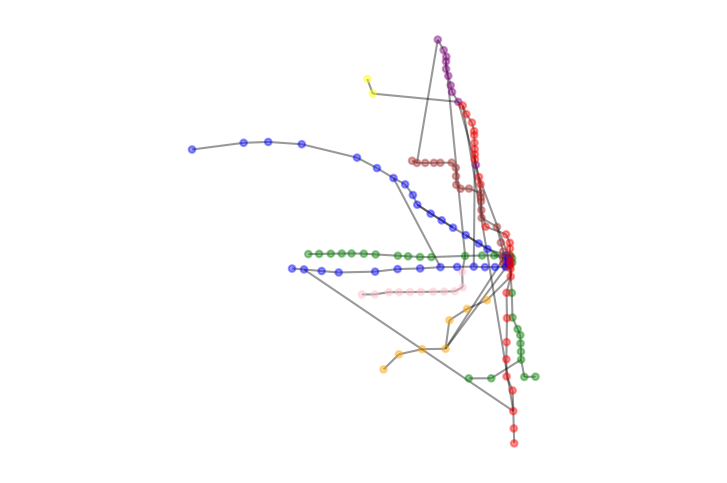

In [17]:
fig, ax = plt.subplots(dpi=150)
nx.draw(G, node_coords, 
        ax=ax, alpha=0.4, 
        node_size=10, 
        node_color=[G.nodes[i]['node_color'] for i in G.nodes])
plt.axis('equal')
plt.grid(which='both')
plt.show()